In [1]:
import logging
import os
import warnings

import pandas as pd
import seaborn as sns

import pcntoolkit.util.output
from pcntoolkit import (
    HBR,
    BsplineBasisFunction,
    CompositeBasisFunction,
    NormalLikelihood,
    NormativeModel,
    NormData,
    make_prior,
    plot_centiles_advanced,
)

sns.set_style("darkgrid")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)

pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)


In [2]:
save_path = os.path.join("pcntoolkit_resources", "data")
os.makedirs(save_path, exist_ok=True)
data_path = os.path.join(save_path, "fcon1000.csv")
if not os.path.exists(data_path):
    data = pd.read_csv(
        "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
    )
    data.to_csv(data_path, index=False)
else:
    data = pd.read_csv(data_path)

# Define the variables
sex_map = {0: "F", 1: "M"}
data["sex"] = data["sex"].map(sex_map)
subject_ids = "sub_id"
covariates = ["age", "EstimatedTotalIntraCranialVol"]
batch_effects = ["sex", "site"]
response_vars = ["CortexVol"]

data = NormData.from_dataframe("fcon1000", data, covariates, batch_effects, response_vars)
train, test = data.train_test_split()

In [3]:
CompositeBasisFunction(
        (BsplineBasisFunction(basis_column=0, degree=3, nknots=5), BsplineBasisFunction(basis_column=1, degree=3, nknots=5))
    ),


(<pcntoolkit.math_functions.basis_function.CompositeBasisFunction at 0x319c05700>,)

In [7]:
mu = make_prior(
    # Mu is linear because we want to allow the mean to vary as a function of the covariates.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 10.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 5.0)),
    # The intercept is random, because we expect the intercept to vary between sites and sexes.

    intercept=make_prior(
        random=True,
        # Mu is the mean of the intercept, which is normally distributed with a mean of 0 and a standard deviation of 1.
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
        # Sigma is the scale at which the intercepts vary. It is a positive parameter, so we have to map it to the positive domain.
        sigma=make_prior(dist_name="Gamma", dist_params=(1.0, 1.0))
    ),
        # We use a B-spline basis function to allow for non-linearity in the mean.
    basis_function=CompositeBasisFunction(
        (BsplineBasisFunction(basis_column=0, degree=3, nknots=5), BsplineBasisFunction(basis_column=1, degree=3, nknots=5))
    ),
)
sigma = make_prior(
    # Sigma is also linear, because we want to allow the standard deviation to vary as a function of the covariates: heteroskedasticity.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 2.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    # The intercept is not random, because we assume the intercept of the variance to be the same for all sites and sexes.
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    # We use a B-spline basis function to allow for non-linearity in the standard deviation.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    # We use a softplus mapping to ensure that sigma is strictly positive.
    mapping="softplus",
    # We scale the softplus mapping by a factor of 3, to avoid spikes in the resulting density.
    # The parameters (a, b, c) provided to a mapping f are used as: f_abc(x) = f((x - a) / b) * b + c
    # This basically provides an affine transformation of the softplus function.
    # a -> horizontal shift
    # b -> scaling
    # c -> vertical shift
    # You can leave c out, and it will default to 0.
    mapping_params=(0.0, 2.0),
)


# Set the likelihood with the priors we just created.
likelihood = NormalLikelihood(mu, sigma)

template_hbr = HBR(
    name="template",
    # The number of cores to use for sampling.
    cores=16,
    # Whether to show a progress bar during the model fitting.
    progressbar=True,
    # The number of draws to sample from the posterior per chain.
    draws=1500,
    # The number of tuning steps to run.
    tune=500,
    # The number of MCMC chains to run.
    chains=4,
    # The sampler to use for the model.
    nuts_sampler="nutpie",
    # The likelihood function to use for the model.
    likelihood=likelihood,
)

In [8]:
model = NormativeModel(
    # The regression model to use for the normative model.
    template_regression_model=template_hbr,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=True,
    # The directory to save the model, results, and plots.
    save_dir="resources/composite_basis/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robminmax", "none"
    outscaler="standardize",
)

In [12]:
model.fit_predict(train, test)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,4,0.09,319
,2000,28,0.11,31
,2000,18,0.09,383
,2000,15,0.08,255


<xarray.NormData> Size: 53kB
Dimensions:            (observations: 216, response_vars: 1, covariates: 2,
                        batch_effect_dims: 2, statistic: 11, centile: 5)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U9 36B 'CortexVol'
  * covariates         (covariates) <U29 232B 'age' 'EstimatedTotalIntraCrani...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
Data variables:
    subject_ids        (observations) int64 2kB 756 769 692 616 ... 751 470 1043
    Y                  (observations, response_vars) float64 2kB 4.579e+05 .....
    X                  (observations, covariates) float64 3kB 63.0 ... 1.603e+06
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 2kB -0.1584 ... ...
    logp               (observations, response_vars) float64 2kB -0.05458 ......
    Yhat               (observations, response_vars) float64 2kB 4.611e+05 .....
    statistics         (response_vars, statistic) float64 88B 0.6692 ... 0.9799
    centiles           (centile, observations, response_vars) float64 9kB 4.2...
Attributes:
    real_ids:                       False
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {np.str_('sex'): [np.str_('F'), np.str_('...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('age'): {'mean': np.float64(28.2...
    batch_effect_covariate_ranges:  {np.str_('sex'): {np.str_('F'): {np.str_(...

In [13]:
model.covariates

['age', 'EstimatedTotalIntraCranialVol']

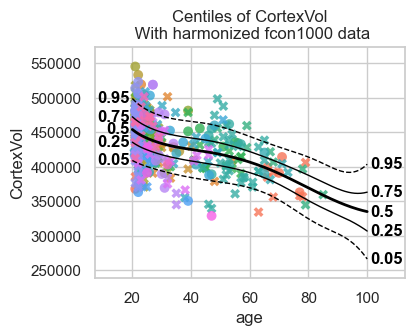

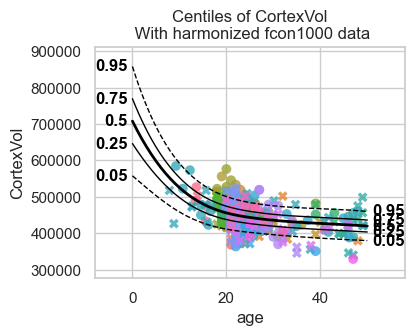

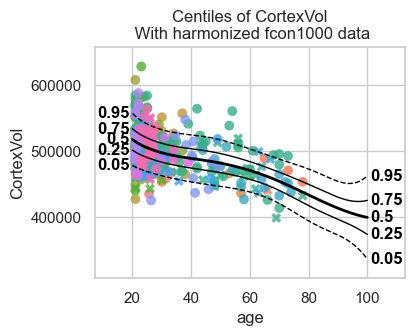

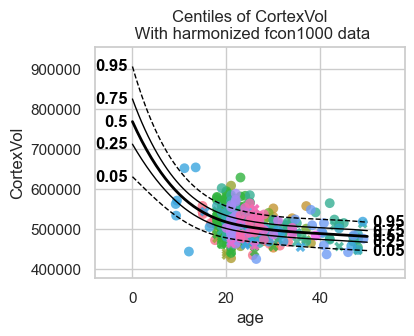

In [14]:
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)


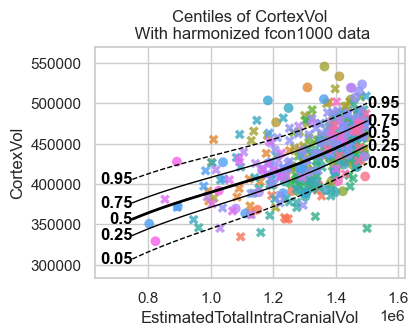

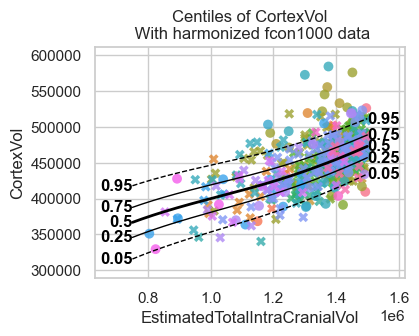

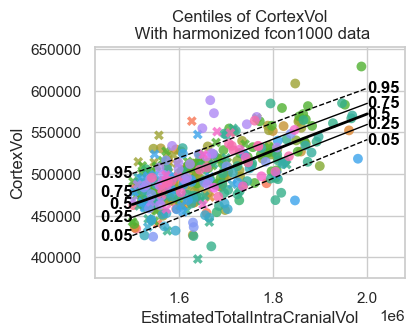

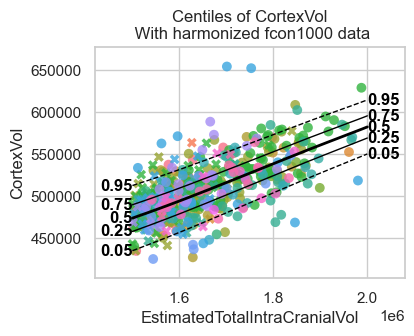

In [15]:
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)